<a href="https://colab.research.google.com/github/yusica09/seoul-AI-hub-study/blob/main/4%EC%A3%BC%EC%B0%A8/Semiconductor_thin_film_layer_prediction_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 반도체 박막 두께 분석

### 배경

최근 고사양 반도체 수요가 많아지면서 반도체를 수직으로 적층하는 3차원 공정이 많이 연구되고 있습니다. 반도체 박막을 수십 ~ 수백 층 쌓아 올리는 공정에서는 박막의 결함으로 인한 두께와 균일도가 저하되는 문제가 있습니다. 이는 소자 구조의 변형을 야기하며 성능 하락의 주요 요인이 됩니다. 이를 사전에 방지하기 위해서는 박막의 두께를 빠르면서도 정확히 측정하는 것이 중요합니다.

박막의 두께를 측정하기 위해 광스펙트럼 분석이 널리 사용되고 있습니다. 하지만 광 스펙트럼을 분석하기 위해서는 관련 지식을 많이 가진 전문가가 필요하며 분석과정에 많은 컴퓨팅자원이 필요합니다. 빅데이터 분석을 통해 이를 해결하고자 반도체 소자의 두께 분석 알고리즘 경진대회를 개최합니다.



### 배경 자료

반도체 박막은 얇은 반도체 막으로 박막의 종류와 두께는 반도체 소자의 특성을 결정짓는 중요한 요소 중 하나입니다. 박막의 두께를 측정하는 방법으로 반사율 측정이 널리 사용되며 반사율은 입사광 세기에 대한 반사광 세기의 비율로 정해집니다. (반사율 = 반사광/입사광) 반사율은 빛의 파장에 따라 변하며 파장에 따른 반사율의 분포를 반사율 스펙트럼이라고 합니다.



### 구조 설명

이번 대회에서 분석할 소자는 질화규소(layer_1)/이산화규소(layer_2)/질화규소(layer_3)/이산화규소(layer_4)/규소(기판) 총 5층 구조로 되어 있습니다. 대회의 목적은 기판인 규소를 제외한 layer_1 ~ layer_4의 두께를 예측하는 것으로 학습 데이터 파일에는 각 층의 두께와 반사율 스펙트럼이 포함되어 있습니다.



### 데이터 설명

train.csv 파일에는 4층 박막의 두께와 파장에 따른 반사율 스펙트럼이 주어집니다. 헤더의 이름에 따라 layer_1 ~ 4는 해당 박막의 두께,

데이터값인 0 ~ 225은 빛의 파장에 해당하는 반사율이 됩니다. 헤더 이름인 0~225은 파장을 뜻하며 비식별화 처리가 되어있어 실제 값과는 다릅니다.

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
use_colab = True
assert use_colab in [True, False]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 데이터 로드
* 새로운 버전의 Colab파일에선 왼쪽의 폴더 tree에서 직접 드라이브 마운트를 진행해야합니다.

In [4]:
train_d = np.load("/content/drive/MyDrive/Datasets/semicon_train_data.npy")
test_d = np.load("/content/drive/MyDrive/Datasets/semicon_test_data.npy")

# train data path
# train_d = np.load("./semicon_train_data.npy")

# test data path
# train_d = np.load("./semicon_test_data.npy")
print(train_d.shape, test_d.shape)

(729000, 230) (81000, 230)


In [5]:
print(train_d[1].shape)

(230,)


In [6]:
print(test_d[0].shape)

(230,)


In [7]:
# Raw Data 확인
print(train_d[1000])
# print(test_d[0])

[7.00000000e+01 4.00000000e+01 1.50000000e+02 1.10000000e+02
 4.02068880e-01 4.05173400e-01 4.22107550e-01 4.35197980e-01
 4.66261860e-01 4.67785980e-01 4.76300870e-01 5.07203700e-01
 5.23296600e-01 5.31541170e-01 5.23319200e-01 5.32340650e-01
 5.38513840e-01 5.62478700e-01 5.74338900e-01 5.62083540e-01
 5.83467800e-01 5.88462350e-01 5.89606940e-01 5.93186560e-01
 5.93241930e-01 5.98241150e-01 5.87171000e-01 5.92055500e-01
 6.06527860e-01 5.87087870e-01 5.94492100e-01 5.73233500e-01
 5.94926300e-01 5.76777600e-01 5.70286300e-01 5.76913000e-01
 5.52754400e-01 5.61735150e-01 5.52500000e-01 5.23800200e-01
 5.11056840e-01 5.11732600e-01 4.92525460e-01 4.73373200e-01
 4.57444160e-01 4.53428800e-01 4.19270130e-01 3.87709920e-01
 3.87221520e-01 3.49848450e-01 3.16229370e-01 3.13858700e-01
 2.80085700e-01 2.61263000e-01 2.30250820e-01 1.98457850e-01
 1.53500440e-01 1.36026740e-01 1.08726785e-01 8.95344000e-02
 6.58975300e-02 5.09539300e-02 3.69604570e-02 2.88708470e-02
 1.54857090e-02 1.995940

* 데이터를 분석하여 모델에 학습할 수 있는 형태로 정리합니다.

In [8]:
train = train_d[:,4:] # 729000, 230 4번째 데이터부터 가져온다.
label = train_d[:,:4]

t_train = test_d[:,4:] # 81000, 230개 4번째 까지 데이터를 가져온다.
t_label = test_d[:,:4]

In [9]:
batch_size = 256

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train, label))
train_dataset = train_dataset.shuffle(10000).repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((t_train, t_label))
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 226), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 226), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>


### 모델 구성
* 현재 가장 간단한 모델로 구성되어 있습니다.
* 데이터셋 자체를 가장 잘 학습할 수 있는 모델을 구현해 학습을 진행합니다.

In [10]:
8 * 8 * 4

256

In [11]:
# Conv2D

# input_tensor = layers.Input(shape=(226,))

# x = layers.Dense(8 * 8 * 4, activation='relu')(input_tensor)
# x = layers.Reshape(target_shape=(8, 8, 4))(x)

# x = layers.Conv2D(16, 8, padding='same', activation='relu')(x)
# skip_1 = layers.Conv2D(16, 8, strides=2, padding='same', activation='relu')(x)
# skip_1 = layers.Dropout(0.3)(skip_1)

# x = layers.Conv2D(32, 8, padding='same', activation='relu')(skip_1)
# x = tf.concat([x, skip_1], -1)
# skip_2 = layers.Conv2D(32, 8, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv2D(64, 8, padding='same', activation='relu')(skip_2)
# x = tf.concat([x, skip_2], -1)
# skip_3 = layers.Conv2D(64, 8, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv2D(128, 8, padding='same')(skip_3)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = tf.concat([x, skip_3], -1)
# x = layers.Conv2D(128, 8, strides=2, padding='same', activation='relu')(x)

# x = layers.Flatten()(x)
# x = layers.Dense(64)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)

# output_tensor = layers.Dense(4)(x)

# model = tf.keras.Model(input_tensor, output_tensor)

In [12]:
# Conv1D

# input_tensor = layers.Input(shape=(226,))

# x = layers.Dense(8 * 8 * 4, activation='relu')(input_tensor)
# x = layers.Reshape(target_shape=(8, 8, 4))(x)

# x = layers.Conv1D(16, 4, padding='same', activation='relu')(x)
# skip_1 = layers.Conv1D(16, 4, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv1D(32, 4, padding='same', activation='relu')(skip_1)
# x = tf.concat([x, skip_1], axis=-1)
# skip_2 = layers.Conv1D(32, 4, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv1D(64, 4, padding='same', activation='relu')(skip_2)
# x = layers.Conv1D(64, 4, padding='same', activation='relu')(x)
# x = tf.concat([x, skip_2], -1)
# skip_3 = layers.Conv1D(64, 4, strides=2, padding='same', activation='relu')(x)

# x = layers.Conv1D(128, 4, padding='same', activation='relu')(skip_3)
# x = layers.Conv1D(128, 4,padding='same', activation='relu')(x)
# x = tf.concat([x, skip_3], -1)
# x = layers.Conv1D(128, 4, strides=2, padding='same', activation='relu')(x)
# x = layers.Dropout(0.3)(x)

# x = layers.Flatten()(x)
# x = layers.Dense(64)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)


# output_tensor = layers.Dense(4)(x)

# model = tf.keras.Model(input_tensor, output_tensor)

In [23]:
# LSTM

input_tensor = layers.Input(shape=(226,))

x = layers.Dense(64 * 4, activation='relu')(input_tensor)
x = layers.Reshape(target_shape=(64, 4))(x)

x = layers.GRU(64, return_sequences=True, recurrent_initializer='glorot_uniform')(x)
x = layers.GRU(128, return_sequences=True, recurrent_initializer='glorot_uniform')(x)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(4)(x)

model = tf.keras.Model(input_tensor, output_tensor)

### 모델 학습
* 4개층의 박막의 두께를 예측하는 모델을 학습해봅시다.

In [24]:
# the save point
if use_colab:
    checkpoint_dir ='./drive/My Drive/train_ckpt/semiconductor/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'semiconductor/exp1'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [25]:
model.compile(loss='mae', #mse
              optimizer='adam',
              metrics=['mae']) #mse

In [26]:
history = model.fit(train_dataset,
                    steps_per_epoch=len(train) / batch_size, # train data의 길이 // batch 길이
                    epochs=15,
                    validation_data=test_dataset,
                    validation_steps=len(t_train) / batch_size)

Epoch 1/15
2847/2847 [==============================] - 43s 13ms/step - loss: 75.8299 - mae: 75.8299 - val_loss: 52.3262 - val_mae: 52.3262
Epoch 2/15
2847/2847 [==============================] - 38s 13ms/step - loss: 44.0139 - mae: 44.0139 - val_loss: 38.0202 - val_mae: 38.0202
Epoch 3/15
2847/2847 [==============================] - 36s 13ms/step - loss: 33.8057 - mae: 33.8057 - val_loss: 30.0503 - val_mae: 30.0503
Epoch 4/15
2847/2847 [==============================] - 37s 13ms/step - loss: 28.2996 - mae: 28.2996 - val_loss: 25.6654 - val_mae: 25.6654
Epoch 5/15
2847/2847 [==============================] - 36s 13ms/step - loss: 24.9388 - mae: 24.9388 - val_loss: 22.7210 - val_mae: 22.7210
Epoch 6/15
2847/2847 [==============================] - 37s 13ms/step - loss: 22.6844 - mae: 22.6844 - val_loss: 21.6674 - val_mae: 21.6674
Epoch 7/15
2847/2847 [==============================] - 36s 13ms/step - loss: 21.0951 - mae: 21.0951 - val_loss: 21.4441 - val_mae: 21.4441
Epoch 8/15
2847/2847

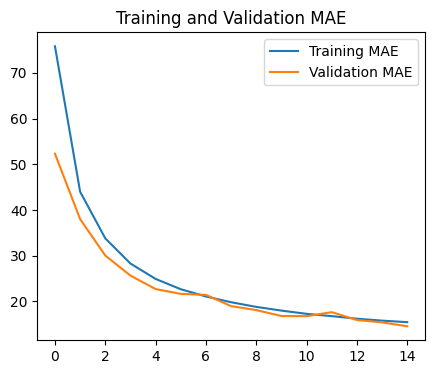

In [29]:
# np.save("file/path.npy", history.numpy())
# history = np.load("histoy.npy", allow_pickle=True)

loss=history.history['mae'] # mse
val_loss=history.history['val_mae'] # val_mse

epochs_range = range(len(loss))

plt.figure(figsize=(5, 4))
plt.plot(epochs_range, loss, label='Training MAE') # MSE
plt.plot(epochs_range, val_loss, label='Validation MAE') # MSE
plt.legend(loc='upper right')
plt.title('Training and Validation MAE') # MSE
plt.show()

### 모델 평가
* Mean absolute error 를 이용해 모델이 정확히 예측하는지를 확인

In [30]:
# model.load_weights(checkpoint_dir)
results = model.evaluate(test_dataset)
print("MAE :", results[0]) # MAE

317/317 [==============================] - 2s 6ms/step - loss: 14.5767 - mae: 14.5767
MAE : 14.576671600341797
